## Machine Learning Assignment 1
### Murtaza Hussain(29449) and Muhammad Asad(29456)
UCI-ML Dataset Link: https://archive.ics.uci.edu/dataset/379/website+phishing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from scipy.io import arff
import zipfile
import os

In [2]:
# Data Loader loads data from UCI-ML Repo
def load_dataset():
    # Download, extract and load Dataset
    flag = False
    dataset_folder = 'website_phishing_data'
    if os.path.exists(dataset_folder):
        files = os.listdir(dataset_folder)
        for file in files:
            if file.endswith(".arff"):
                flag = True
        if flag == False:
            os.rmdir(dataset_folder)

    if flag == False:
        urllib.request.urlretrieve('https://archive.ics.uci.edu/static/public/379/website+phishing.zip', 'website_phishing.zip')
        with zipfile.ZipFile('website_phishing.zip', 'r') as zip_ref:
            zip_ref.extractall('website_phishing_data')
    names = os.listdir(dataset_folder)
    input = ''
    for name in names:
        if name.endswith(".arff"):
            input = name
            break
    
    phishing_data, meta = arff.loadarff(f'{dataset_folder}/{input}')
    phishing_data = pd.DataFrame(phishing_data)

    for column in phishing_data.columns:
        if phishing_data[column].dtype == 'object':  # Only apply to columns with object dtype
            phishing_data[column] = phishing_data[column].str.decode('utf-8')
            phishing_data[column] = phishing_data[column].astype(int)

            


    # data (as pandas dataframes) 
    x = phishing_data.drop(['Result'], axis=1)
    y = phishing_data[['Result']] 
    z = phishing_data

    # metadata 
    print(meta) 

    return x, y, z

features, targets, original = load_dataset()

Dataset: 'Phishing-weka.filters.supervised.attribute.AttributeSelection-Eweka.attributeSelection.InfoGainAttributeEval-Sweka.attributeSelection.Ranker
	SFH's type is nominal, range is ('1', '-1', '0')
	popUpWidnow's type is nominal, range is ('-1', '0', '1')
	SSLfinal_State's type is nominal, range is ('1', '-1', '0')
	Request_URL's type is nominal, range is ('-1', '0', '1')
	URL_of_Anchor's type is nominal, range is ('-1', '0', '1')
	web_traffic's type is nominal, range is ('1', '0', '-1')
	URL_Length's type is nominal, range is ('1', '-1', '0')
	age_of_domain's type is nominal, range is ('1', '-1')
	having_IP_Address's type is nominal, range is ('0', '1')
	Result's type is nominal, range is ('0', '1', '-1')



In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(original)

Column Name: SFH
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: popUpWidnow
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: SSLfinal_State
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: Request_URL
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: URL_of_Anchor
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: web_traffic
Column DataType: int32
Column unique values: [ 1  0 -1]
Column has null: False


Column Name: URL_Length
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: age_of_domain
Column DataType: int32
Column unique values: [ 1 -1]
Column has null: False


Column Name: having_IP_Address
Column DataType: int32
Column unique values: [0 1]
Column has null: False


Column Name: Result
Column DataType: int32
Column 

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

clean_data(original,null_cols,False)

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


In [5]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

transform_data(original)

Categorical columns: Index([], dtype='object')
Numerical columns: Index([], dtype='object')


,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


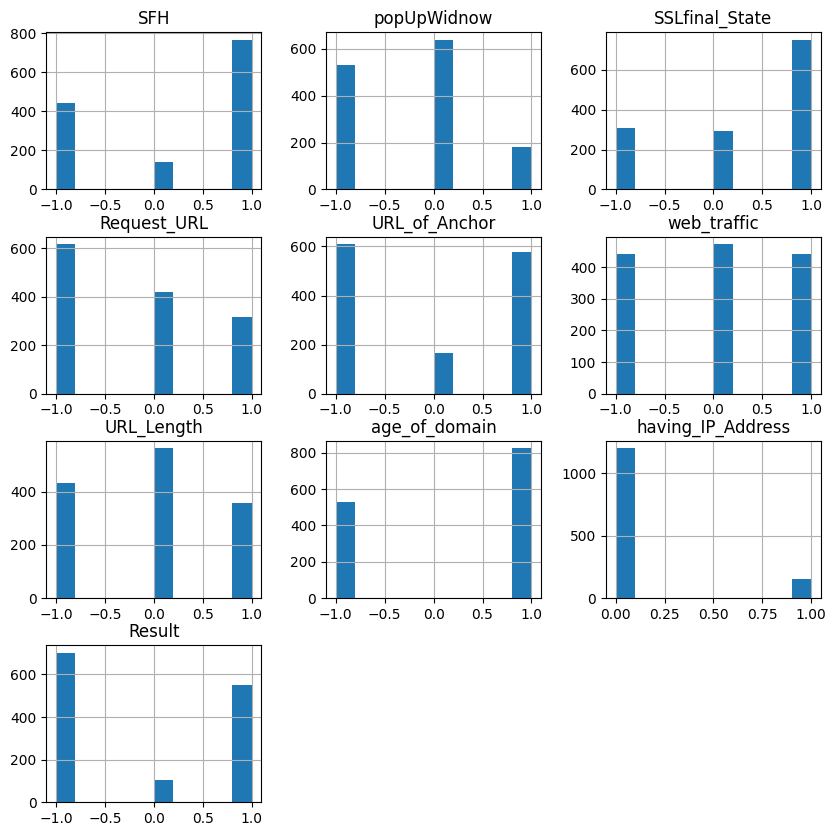

In [6]:
# Creates histograms for categorical data
def plot_histograms(df):
    df.hist(figsize=(10, 10))
    plt.show()

# Creates boxplot for numerical data
def plot_boxplots(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        sns.boxplot(x=df[col])
        plt.show()

plot_histograms(original)
plot_boxplots(original)

In [7]:
# Performs data splitting on a 80:20 ratio
def split_data(df, target_name):
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Performs training and evaluation
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))

In [8]:
# Master Workflow, combines and manages all the workflow from one place
# Specifically Tailored for Mushroom Dataset
def master_workflow():
    features, targets, original = load_dataset()
    null_cols = null_check(original)
    original = clean_data(original,null_cols,False)
    original = transform_data(original)
    plot_histograms(original)
    plot_boxplots(original)
    X_train, X_test, y_train, y_test = split_data(original, targets.columns[0])
    train_and_evaluate(X_train, X_test, y_train, y_test)

Dataset: 'Phishing-weka.filters.supervised.attribute.AttributeSelection-Eweka.attributeSelection.InfoGainAttributeEval-Sweka.attributeSelection.Ranker
	SFH's type is nominal, range is ('1', '-1', '0')
	popUpWidnow's type is nominal, range is ('-1', '0', '1')
	SSLfinal_State's type is nominal, range is ('1', '-1', '0')
	Request_URL's type is nominal, range is ('-1', '0', '1')
	URL_of_Anchor's type is nominal, range is ('-1', '0', '1')
	web_traffic's type is nominal, range is ('1', '0', '-1')
	URL_Length's type is nominal, range is ('1', '-1', '0')
	age_of_domain's type is nominal, range is ('1', '-1')
	having_IP_Address's type is nominal, range is ('0', '1')
	Result's type is nominal, range is ('0', '1', '-1')

Column Name: SFH
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: popUpWidnow
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: SSLfinal_State
Column DataType: int32
Column unique values: [ 1

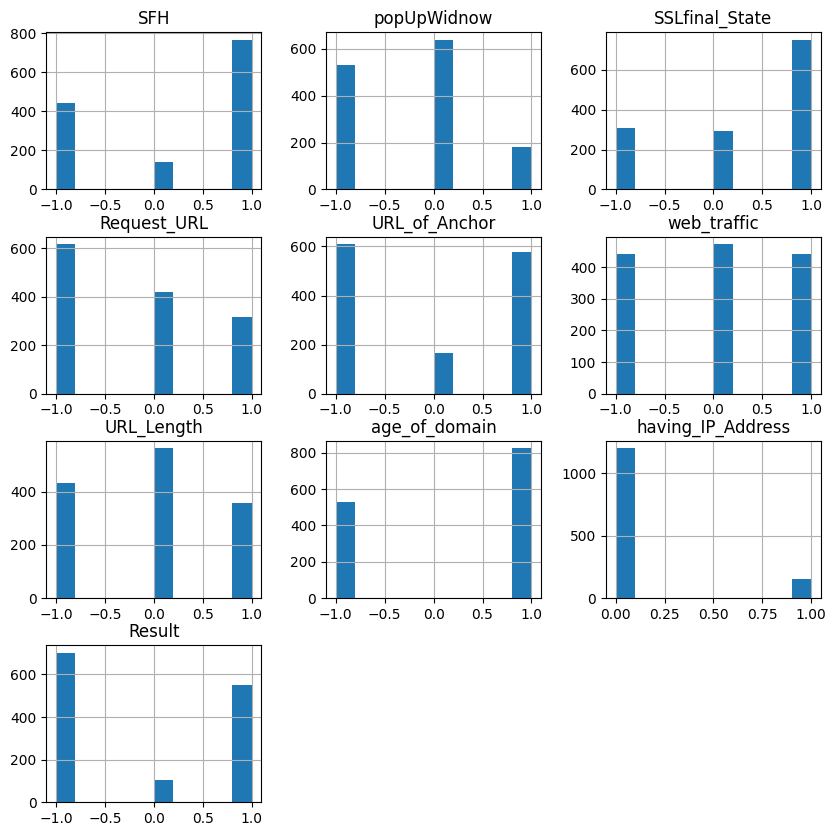

              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       140
           0       0.77      0.48      0.59        21
           1       0.85      0.91      0.88       110

    accuracy                           0.87       271
   macro avg       0.84      0.76      0.79       271
weighted avg       0.87      0.87      0.87       271

Accuracy: 0.8708487084870848


In [9]:
master_workflow()